In [1]:
import torch 
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt


In [2]:
train_data=datasets.FashionMNIST(download=True,train=True,root="data",transform=ToTensor())
test_data=datasets.FashionMNIST(download=True,train=False,root="data",transform=ToTensor())


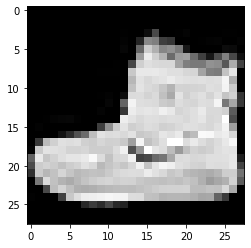

In [3]:
data_sample=train_data[0][0]
plt.imshow(data_sample.squeeze(),cmap="gray")

In [4]:
train_data_loader=DataLoader(dataset=train_data,batch_size=32,shuffle=True)
test_data_loader=DataLoader(dataset=test_data,batch_size=32,shuffle=False)

### Class oluşturmaya kadar gereken işlemler tamamlandı

In [5]:
class FashionModel_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        input_shape=1
        output_shape=10
        hidden_unit=10
        self.cnn_layer_1=nn.Sequential(
            nn.Conv2d(in_channels=input_shape,out_channels=hidden_unit,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_unit,out_channels=hidden_unit,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.cnn_layer_2=nn.Sequential(
            nn.Conv2d(in_channels=hidden_unit,out_channels=hidden_unit,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_unit,out_channels=hidden_unit,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )   
        self.fully_connected_layer=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_unit*7*7,out_features=output_shape)
        )
    def forward(self,x:torch.Tensor):
        x=self.cnn_layer_1(x)
        x=self.cnn_layer_2(x)
        x=self.fully_connected_layer(x)
        return x
        

In [6]:
model=FashionModel_CNN().to("cuda")
model

FashionModel_CNN(
  (cnn_layer_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_layer_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_connected_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [7]:
loss_function=nn.CrossEntropyLoss()
optimazer=torch.optim.SGD(lr=0.01,params=model.parameters())

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [8]:
epochs=10
device="cuda"
train_loss=0
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n-------")
    model.train()
    for batch,(X,y) in enumerate(train_data_loader):
        model.train() # modeli train moda aldık
        X, y = X.to("cuda"), y.to("cuda")# tüm inputların aynı device üzerinde olması gerekiyor.
        y_pred=model(X)
        loss=loss_function(y_pred,y)
        train_loss+= loss
        optimazer.zero_grad()
        loss.backward()
        optimazer.step()
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_data_loader.dataset)} samples")

    train_loss /= len(train_data_loader)

    model.eval()# bu durumda dropuout ve batchnorm gibi işlemler devre dışı bırakılır.
    with torch.inference_mode():# sadece forward propagation yapar. gradiant hesaplanmaz bu sayede parametreler güncellenmez ve bellek optimizasyonu sağlanır.
        test_loss,test_accurancy,test_acc=0,0,0
        for X,y in test_data_loader:
            X, y = X.to("cuda"), y.to("cuda")
            test_pred=model(X)
            test_loss=loss_function(test_pred,y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

        test_loss /= len(test_data_loader)
        test_acc /= len(test_data_loader)

    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")   


Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 1.30188 | Test loss: 0.00100, Test acc: 78.86%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.50948 | Test loss: 0.00063, Test acc: 82.88%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.44542 | Test loss: 0.00059, Test acc: 84.49%

Epoch: 3
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.40976 | Test loss: 0.00074, Test acc: 80.82%

Epoch: 4
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
L

#### Train Adımları
- ilk önce x ve y değişkenini model ile aynı device a eklememiz gerekiyor.
- modelden bir predict yapmasını istiyoruz.
- predict ile true değeri loss function a veriyoruz.
- optim.zero_grad()
- loss.backward() ile back propagation yapıyoruz.
- optim.step() ile back propagation sonucu ile weightleri güncelliyoruz.


#### Model Evaluate Adımları
- model.eval() durumunda geçilir
- gradient hesaplamalarını yapmamak için torch.with_inference() ın içinde işlemler yapılır
- for dongusu ile test_data_loader üzerinde gezinilir. X ve y elde edilir.
- traindeki gibi x ve y aynı device e eklenir ardından model tahmin yapar ve loss oluşturulur.
- accurancy function a y_pred ve y_test gonderilerek accurancy hesaplanır.